# Image Processing with Keras - Capstone Project (Koios Medical)

by Sabbir Mohammed<br><br>*Project Description: Deep Learning Project focused on object localization of potential tumors and legions on thyroid ultrasound images.*<br><br>*This notebook utilizes the Keras framework, running on tensor flow to execute a Convolution Neural Network to train a model. The pre-trained weights used to initialize this model is imported from the Xception model hosted under Keras Applications (link below)*

- - -

<p><a name="home"></a></p>
### SECTIONS:<br>
-  <a href="#colab">  Setting up for Google Colab                   </a><br>
1. <a href="#import"> 1. Importing Data and Initializing            </a><br>
2. <a href="#pre">    2. Keras Preprocessing                        </a><br>
3. <a href="#algo">   3. Setting up Architecture: Importing Xception</a><br>
4. <a href="#train">  4. Training and Fitting Model                 </a><br>
5. <a href="#test">   5. Evaluating Model                           </a><br>
6. <a href="#output"> 6. Final Results of Prediction                </a><br>

- - -

<p><a name="colab"></a></p>
### SETTING UP FOR GOOGLE COLAB:
<a href="#home">BACK TO THE TOP</a>

This notebook was run on the Google Colab platform to make use of the GPU resources available there.

In [0]:
# Mounting Google Drive directory and files
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Changing working directory to match setup in Google Drive
cd '/content/drive/My Drive/ProjectCapstone'

/content/drive/My Drive/ProjectCapstone


In [0]:
# Confirming new working directory
pwd

'/content/drive/My Drive/ProjectCapstone'

In [0]:
# Checking GPU connection
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- - -

<p><a name="import"></a></p>
### 1. IMPORTING DATA AND INITIALIZING:
<a href="#home">BACK TO THE TOP</a>

**a) Initializing libraries and functions**

In [0]:
import pandas             as pd
import numpy              as np
import matplotlib.pyplot  as plt
import tensorflow         as tf
import tf_iou             as tfiou    # customized functions in the directory
import calculate_iou      as calc_iou # customized functions in the directory
import matplotlib.pyplot  as plt
import matplotlib.image   as mpimg
import matplotlib.patches as patches

from PIL import Image

**b) Loading CSV(s)**

In [0]:
train = pd.read_csv('./cimalab/dataframe/train.csv')
train = train.drop('Unnamed: 0', axis=1)

In [0]:
validation = pd.read_csv('./cimalab/dataframe/validation.csv')
validation = validation.drop('Unnamed: 0', axis=1)

In [0]:
test = pd.read_csv('./cimalab/dataframe/test.csv')
test = test.drop('Unnamed: 0', axis=1)

In [0]:
# SANITY CHECK
train.head(2)

,image_id,x1,y1,x2,y2,filename
0,146,311.0,77.0,373.0,126.0,./cimalab/thyroid/106_2.jpg
1,147,258.0,72.0,328.0,123.0,./cimalab/thyroid/106_3.jpg


**c) Scaling bounding box coordinates [0,1] (for sigmoid activation of dense layers, later)**<br>
The following cells are due to different image sizes. Each image size in the data set is random

In [0]:
# TRAINING SET
train['x1p'] = [(train.x1[i]/Image.open(train.filename[i]).size[0]) for i in range(len(train.x1))]
train['y1p'] = [(train.y1[i]/Image.open(train.filename[i]).size[1]) for i in range(len(train.y1))]
train['x2p'] = [(train.x2[i]/Image.open(train.filename[i]).size[0]) for i in range(len(train.x2))]
train['y2p'] = [(train.y2[i]/Image.open(train.filename[i]).size[1]) for i in range(len(train.y2))]

# SANITY CHECK
# train.sample(5)

In [0]:
# VALIDATION SET
validation['x1p'] = [(validation.x1[i]/Image.open(validation.filename[i]).size[0]) for i in range(len(validation.x1))]
validation['y1p'] = [(validation.y1[i]/Image.open(validation.filename[i]).size[1]) for i in range(len(validation.y1))]
validation['x2p'] = [(validation.x2[i]/Image.open(validation.filename[i]).size[0]) for i in range(len(validation.x2))]
validation['y2p'] = [(validation.y2[i]/Image.open(validation.filename[i]).size[1]) for i in range(len(validation.y2))]

# SANITY CHECK
# validation.sample(5)

In [0]:
# TEST SET
test['x1p'] = [(test.x1[i]/Image.open(test.filename[i]).size[0]) for i in range(len(test.x1))]
test['y1p'] = [(test.y1[i]/Image.open(test.filename[i]).size[1]) for i in range(len(test.y1))]
test['x2p'] = [(test.x2[i]/Image.open(test.filename[i]).size[0]) for i in range(len(test.x2))]
test['y2p'] = [(test.y2[i]/Image.open(test.filename[i]).size[1]) for i in range(len(test.y2))]

# SANITY CHECK
# test.sample(5)

In [0]:
# Saving updated .csv(s) as separate files
train.to_csv('./cimalab/dataframe/train_scaled.csv')
validation.to_csv('./cimalab/dataframe/validation_scaled.csv')
test.to_csv('./cimalab/dataframe/test_scaled.csv')

- - -

<p><a name="pre"></a></p>
### 2. KERAS PREPROCESSING:
<a href="#home">BACK TO THE TOP</a>

**a) Initializing**

In [0]:
from keras_preprocessing.image import ImageDataGenerator
from keras.models              import Sequential, load_model
from keras.layers              import Dropout, Flatten, Dense#, Conv2D, MaxPooling2D
from keras                     import optimizers
from keras.callbacks           import ModelCheckpoint, TensorBoard
from keras_preprocessing.image import load_img, img_to_array
from keras.applications        import xception

Using TensorFlow backend.


In [0]:
# Modifying tensor flow setting to manage GPU resources better. 

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


**b) Setting Parameters**

In [0]:
image_width  = 299
image_height = 299
image_size   = (image_width, image_height)
batch_size   = 20

**c) Creating the Train and Validation Data Generators **

In [0]:
# from keras_preprocessing.image import ImageDataGenerator

train_datagen        = ImageDataGenerator(
    rescale          = 1.0/255,
#     rotation_range   = 20,
#     horizontal_flip  = True,
    fill_mode        = 'nearest')

train_generator      = train_datagen.flow_from_dataframe(
    dataframe        = train,
    x_col            = 'filename',
    y_col            = ['x1p','y1p','x2p','y2p'],
    target_size      = image_size,  
    batch_size       = batch_size,
    color_mode       = 'rgb',
    class_mode       = 'other')

#-----------------------------------------------------------------------------------------------------------------#

validation_datagen   = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe        = validation,
    x_col            = 'filename',  
    y_col            = ['x1p','y1p','x2p','y2p'],
    target_size      = image_size,  
    batch_size       = batch_size,
    color_mode       = 'rgb',
    class_mode       = 'other')

Found 1940 images.
Found 647 images.


- - -

<p><a name="algo"></a></p>
### 3.  SETTING UP ARCHITECTURE : IMPORTING XCEPTION<br><https://keras.io/applications/#xception>
<a href="#home">BACK TO THE TOP</a>

**a) Importing Model**

In [0]:
# from keras.applications import xception

conv_base = xception.Xception(
                     weights      = 'imagenet',
                     include_top  = False,
                     input_shape  = (299, 299, 3))

conv_base.trainable = True  # Check with 'True'...

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 6s 0us/step


**b) Building Model Architecture (using pre-trained weights)**

In [0]:
# from keras.models  import Sequential
# from keras.layers  import Dropout

xception_model = Sequential()
xception_model.add(conv_base)
xception_model.add(Flatten())
xception_model.add(Dropout(0.5))                       
xception_model.add(Dense(64,  activation = 'linear')) # attempt with sigmoid activation
xception_model.add(Dense(4,   activation = 'linear')) # attempt with sigmoid activation

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                13107264  
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 33,969,004
Trainable params: 33,914,476
Non-trainable params: 54,528
_________________________________________________________________


**c) Compiling Model Parameters**

In [0]:
# import tf_iou as tfiou

# Making a tf.py_function so that it can be used as a metric in the keras model compiler

def IoU(y_true, y_pred):
    iou = tf.py_function(tfiou.tf_iou, [y_true, y_pred], tf.float32)
    return iou

In [0]:
# from keras import optimizers

xception_model.compile(loss      = 'mean_squared_error',
                       optimizer = optimizers.Adam(),
                       metrics   = [IoU])

<p><a name="train"></a></p>
### 4. TRAINING AND FITTING MODEL (TRAINING and VALIDATION SETS)
<a href="#home">BACK TO THE TOP</a>

**a) Running Epochs**

In [0]:
# from keras.callbacks import ModelCheckpoint, TensorBoard

best_model = ModelCheckpoint("./xception/trial_xception.h5", monitor='val_loss', verbose=0, save_best_only=True)


epoch       = 25
train_steps = (train.shape[0]//batch_size) +1
valid_steps = (validation.shape[0]//batch_size) +1

history     = xception_model.fit_generator(
        train_generator,
        validation_data  = validation_generator,    
        steps_per_epoch  = train_steps,
        validation_steps = valid_steps,
        epochs           = epoch,
        callbacks        =[best_model, TensorBoard(log_dir='./xception/logs')])

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
98/98 [==============================] - 115s 1s/step - loss: 51.4651 - IoU: 0.2479 - val_loss: 0.1787 - val_IoU: 0.2972
Epoch 2/25
98/98 [==============================] - 102s 1s/step - loss: 0.1369 - IoU: 0.3512 - val_loss: 0.1102 - val_IoU: 0.4102
Epoch 3/25
98/98 [==============================] - 103s 1s/step - loss: 0.0833 - IoU: 0.4689 - val_loss: 0.0667 - val_IoU: 0.5217
Epoch 4/25
98/98 [==============================] - 102s 1s/step - loss: 0.0520 - IoU: 0.5729 - val_loss: 0.0418 - val_IoU: 0.6151
Epoch 5/25
98/98 [==============================] - 104s 1s/step - loss: 0.0342 - IoU: 0.6478 - val_loss: 0.0277 - val_IoU: 0.6810
Epoch 6/25
98/98 [==============================] - 103s 1s/step - loss: 0.0240 - IoU: 0.6980 - val_loss: 0.0195 - val_IoU: 0.7261
Epoch 7/25
98/98 [==============================] - 102s 1s/step - loss: 0.0179 - IoU: 0.7350 - val_loss: 0.0145 - val_IoU: 0.7589
Epoch 8/25
98/98 [================

**b) Loss and Accuracy (IoU Values) for Training and Validation Sets over Epochs**

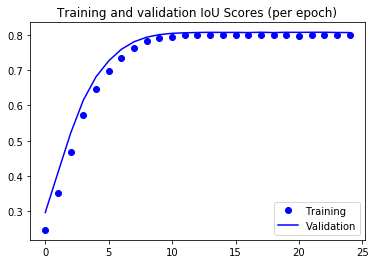

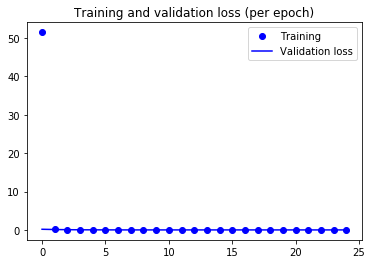

In [0]:
acc      = history.history['IoU']
val_acc  = history.history['val_IoU']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))

plt.plot  (epochs, acc, 'bo',    label = 'Training')
plt.plot  (epochs, val_acc, 'b', label = 'Validation')
plt.title ('Training and Validation IoU Scores (per epoch)')
plt.legend()

plt.figure()

plt.plot  (epochs, loss, 'bo', label='Training')
plt.plot  (epochs, val_loss, 'b', label='Validation loss')
plt.title ('Training and Validation MSE loss (per epoch)')
plt.legend()

plt.show  ()

<p><a name="test"></a></p>
### 5. EVALUATING (TRAINED) MODEL PERFORMANCE ON TEST SET
<a href="#home">BACK TO THE TOP</a>

**a) Setting up Test Set Generator and Running Model for Predicted Values**

In [0]:
# Creating a keras generator object for the test set

test_datagen    = ImageDataGenerator(rescale=1.0/255) # we only need to scale the input for validation set

test_generator  = test_datagen.flow_from_dataframe(
    dataframe   = test,
    x_col       = 'filename',  
    y_col       = ['x1p','y1p','x2p','y2p'],
    target_size = image_size,  
    batch_size  = batch_size,
    color_mode  = 'rgb',
    class_mode  = 'other')

Found 647 images.


In [0]:
# Predicting bounding box coordinates on test set

test_steps = (len(test)//batch_size) +1

Test_results = xception_model.predict_generator(
    test_generator, 
    steps               = test_steps, 
#   callbacks           = None, 
    max_queue_size      = batch_size, 
    workers             = 0, 
    use_multiprocessing = False, 
    verbose             = 1)

33/33 [==============================] - 10s 303ms/step


**b) Formatting Predicted Results for Output/ Evaluation**

In [0]:
# Creating data frames to evaluate model performance

Predicted   = pd.DataFrame(data = Test_results, columns = ['x1','y1','x2','y2'])
GroundTruth = test[['x1','y1','x2','y2']]

In [0]:
# Rescaling output values back to actual pixels for evaluation

Predicted['x1'] = [(Predicted.x1[i]*Image.open(test.filename[i]).size[0]) for i in range(len(test.x1))]
Predicted['y1'] = [(Predicted.y1[i]*Image.open(test.filename[i]).size[1]) for i in range(len(test.y1))]
Predicted['x2'] = [(Predicted.x2[i]*Image.open(test.filename[i]).size[0]) for i in range(len(test.x2))]
Predicted['y2'] = [(Predicted.y2[i]*Image.open(test.filename[i]).size[1]) for i in range(len(test.y2))]

**c) Creating IoU values for Each Predicted Observation**

In [0]:
# import calculate_iou as calc_iou

# Collecting IoU scores per prediction

scores = []

for i in range(len(GroundTruth)):
    score = calc_iou.calculate_iou(np.array(GroundTruth.iloc[i]), np.array(Predicted.iloc[i]))
    scores.append(round(score,4))

In [0]:
# Mean IoU Scores
np.mean(scores)

0.42306137

In [0]:
# Checking for min and max scores
sb = pd.Series(scores)
sb[sb==np.max(sb)]

197    0.7844
dtype: float64

In [0]:
# Checking for negative values
sc = pd.Series(scores)
sc = sc[sc<0]
sc

Series([], dtype: float64)

In [0]:
#Printing scores to csv
pd.Series(scores).to_csv('./xception/iou_scores_trial.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


<p><a name="output"></a></p>
### 6. FINAL RESULTS OF PREDICTION: 
<a href="#home">BACK TO THE TOP</a>

*CHECKING INDIVIDUAL IMAGES FOR GROUND TRUTH AND PREDICTED BOUNDING BOXES*

In [0]:
# from PIL import Image
# import matplotlib.pyplot as plt
# import matplotlib.image  as mpimg
# import matplotlib.patches as patches

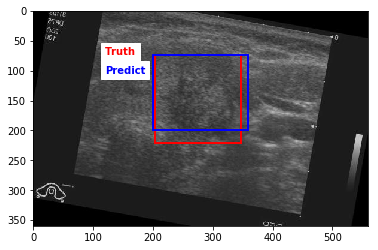

In [0]:
x = 197

g = GroundTruth.iloc[x]
p = Predicted.iloc[x]

%matplotlib inline

img = np.array(Image.open(test.filename[x]), dtype = np.uint8)
fig,ax = plt.subplots(1)
ax.imshow(img)

GT     = patches.Rectangle((g[0],g[1]), g[2]-g[0], g[3]-g[1], linewidth=2,edgecolor='r',fill=False)
PB     = patches.Rectangle((p[0],p[1]), p[2]-p[0], p[3]-p[1], linewidth=2,edgecolor='b',fill=False)

ax.add_patch(GT)
ax.add_patch(PB)
plt.text(g[0]-84,g[1], 'Truth',  color='r', fontweight='bold', backgroundcolor='w')
plt.text(p[0]-80,p[1]+30, 'Predict',color='b', fontweight='bold', backgroundcolor='w')

plt.show()

# 197, 420, 332, 386 #dice function

- - -

THANK YOU FOR VIEWING MY CODE!

- - -

[IGNORE]

In [0]:
# USE ONLY IF MODEL IS NEEDED TO BE LOADED AGAIN

# from keras.models import load_model
# model = load_model("./xception/trial_5_xception.h5")

# dependencies = {'metrics': [IoU]}
# model = load_model("./xception/trial_5_xception.h5", custom_objects=dependencies)